In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

## Data Collection/Processing:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Loading MNIST Dataset
trans = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# training and test datasets
training_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=trans)
testing_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=trans)

## Data Preprocessing

In [2]:
training_size = int(0.8 * len(training_data))
val_size = len(training_data) - training_size
training_set, val_set = random_split(training_data, [training_size, val_size])

# Creating data loaders
training_loader = DataLoader(training_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
testing_loader = DataLoader(testing_data, batch_size=64, shuffle=False)

## Model training

Baseline CNN
Epoch 1/10, Loss: 0.1723, Train Acc: 94.77%, Val Loss: 0.0645, Val Acc: 97.97%
Epoch 2/10, Loss: 0.0486, Train Acc: 98.51%, Val Loss: 0.0457, Val Acc: 98.57%
Epoch 3/10, Loss: 0.0325, Train Acc: 98.94%, Val Loss: 0.0493, Val Acc: 98.46%
Epoch 4/10, Loss: 0.0243, Train Acc: 99.23%, Val Loss: 0.0373, Val Acc: 98.88%
Epoch 5/10, Loss: 0.0161, Train Acc: 99.47%, Val Loss: 0.0797, Val Acc: 97.94%
Epoch 6/10, Loss: 0.0151, Train Acc: 99.49%, Val Loss: 0.0390, Val Acc: 98.82%
Epoch 7/10, Loss: 0.0109, Train Acc: 99.66%, Val Loss: 0.0369, Val Acc: 99.00%
Epoch 8/10, Loss: 0.0080, Train Acc: 99.74%, Val Loss: 0.0510, Val Acc: 98.82%
Epoch 9/10, Loss: 0.0091, Train Acc: 99.68%, Val Loss: 0.0655, Val Acc: 98.51%
Epoch 10/10, Loss: 0.0063, Train Acc: 99.79%, Val Loss: 0.0516, Val Acc: 98.85%


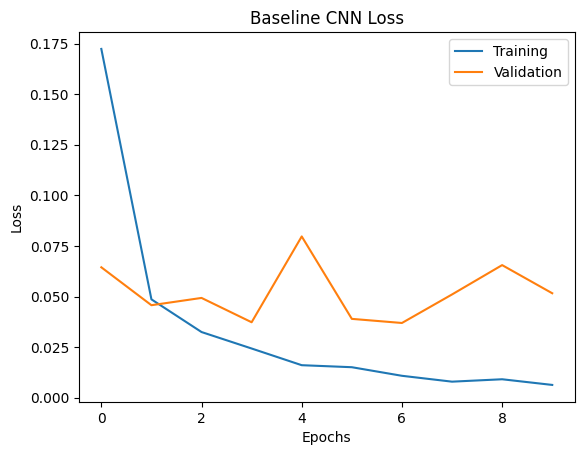

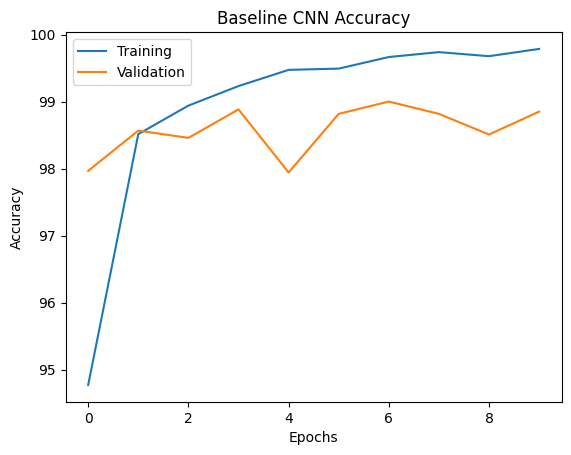

Test Accuracy: 99.04%


In [4]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc_1 = nn.Linear(64 * 7 * 7, 128)
        self.fc_2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv_1(x)))
        x = self.pool(F.relu(self.conv_2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

def calc_rmse(predictions, labels):
    return torch.sqrt(torch.mean((predictions - labels.float()) ** 2))

def train_model(model, training_loader, val_loader, epochs=10, learning_rate=0.001):
    opt = optim.Adam(model.parameters(), lr=learning_rate)
    crt = nn.CrossEntropyLoss()

    train_loss_his, val_loss_list = [], []
    train_acc, val_acc_history = [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in training_loader:
            opt.zero_grad()
            outputs = model(images)
            loss = crt(outputs, labels)
            loss.backward()
            opt.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(training_loader)
        train_accuracy = 100 * correct / total
        train_loss_his.append(train_loss)
        train_acc.append(train_accuracy)

        # Validate the model
        val_loss, val_accuracy = validate_model(model, val_loader, crt)
        val_loss_list.append(val_loss)
        val_acc_history.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    return train_loss_his, val_loss_list, train_acc, val_acc_history

def validate_model(model, val_loader, crt):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = crt(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy

# Plotting function for training/validation loss and accuracy
def plot_metrics(train_values, val_values, ylabel, title):
    plt.plot(train_values, label='Training')
    plt.plot(val_values, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)
    plt.show()

print("Baseline CNN")
basic_cnn = BasicCNN()
train_loss_basic, val_loss_basic, train_acc_basic, val_acc_basic = train_model(basic_cnn, training_loader, val_loader, epochs=10, learning_rate=0.001)

# plotting
plot_metrics(train_loss_basic, val_loss_basic, 'Loss', 'Baseline CNN Loss')
plot_metrics(train_acc_basic, val_acc_basic, 'Accuracy', 'Baseline CNN Accuracy')


In [15]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc_1 = nn.Linear(64 * 7 * 7, 128)
        self.fc_2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv_1(x)))
        x = self.pool(F.relu(self.conv_2(x)))
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc_1(x))
        x = self.dropout(x)
        x = self.fc_2(x)
        return x

print("\n----Improved CNN----")
imp_cnn = ImprovedCNN()
train_loss_imp, val_loss_imp, train_acc_imp, val_acc_imp = train_model(imp_cnn, training_loader, val_loader, epochs=10, learning_rate=0.0005)


----Improved CNN----
Epoch 1/10, Loss: 0.2714, Train Acc: 91.92%, Val Loss: 0.0683, Val Acc: 98.01%
Epoch 2/10, Loss: 0.0784, Train Acc: 97.65%, Val Loss: 0.0544, Val Acc: 98.42%
Epoch 3/10, Loss: 0.0537, Train Acc: 98.31%, Val Loss: 0.0441, Val Acc: 98.64%
Epoch 4/10, Loss: 0.0437, Train Acc: 98.62%, Val Loss: 0.0416, Val Acc: 98.77%
Epoch 5/10, Loss: 0.0368, Train Acc: 98.78%, Val Loss: 0.0404, Val Acc: 98.85%
Epoch 6/10, Loss: 0.0287, Train Acc: 99.10%, Val Loss: 0.0363, Val Acc: 99.03%
Epoch 7/10, Loss: 0.0252, Train Acc: 99.18%, Val Loss: 0.0363, Val Acc: 98.91%
Epoch 8/10, Loss: 0.0219, Train Acc: 99.29%, Val Loss: 0.0416, Val Acc: 98.88%
Epoch 9/10, Loss: 0.0188, Train Acc: 99.32%, Val Loss: 0.0390, Val Acc: 98.90%
Epoch 10/10, Loss: 0.0156, Train Acc: 99.48%, Val Loss: 0.0401, Val Acc: 99.04%


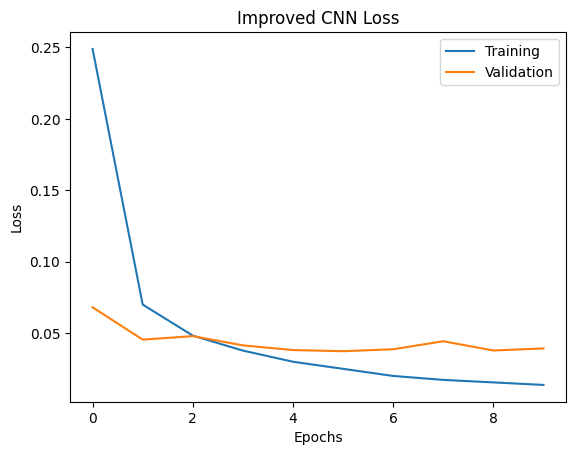

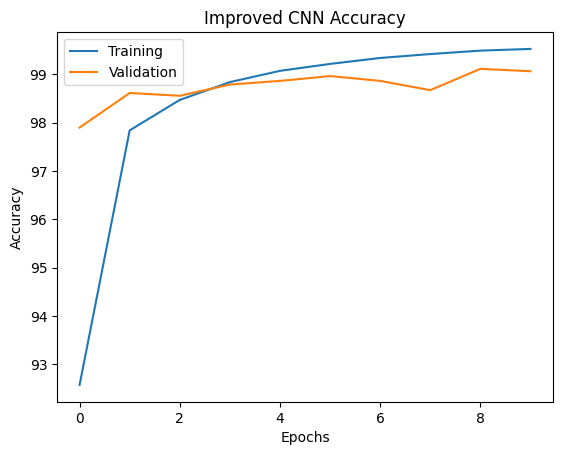

In [14]:
# Plot for Improved CNN
plot_metrics(train_loss_imp, val_loss_imp, 'Loss', 'Improved CNN Loss')
plot_metrics(train_acc_imp, val_acc_imp, 'Accuracy', 'Improved CNN Accuracy')

## Testing

In [13]:
def test_model(model, testing_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testing_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy of the Improved CNN model is : {accuracy:.2f}%')
    return accuracy
    
improved_cnn_accuracy = test_model(imp_cnn, testing_loader)

Test Accuracy of the Improved CNN model is : 99.26%
